In [135]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

import torchvision
from torchvision import transforms

from torch.utils.data import DataLoader
from torchvision.utils import make_grid

%matplotlib inline

In [197]:
DATA_DIR = 'data'

BATCH_SIZE = 64

RELU_NEG_SLOPE = 0.2

## Vanilla Convolutional AE on MNIST

In [204]:
def get_mnist_ds(train: bool):

    return torchvision.datasets.MNIST(DATA_DIR, 
                                      train=train, 
                                      transform=transforms.Compose([
                                                    transforms.ToTensor(),
                                                    transforms.Normalize((0.5,), (0.5,))
                                                ]), 
                                      target_transform=None, 
                                      download=True)

def get_mnist_dls():
    
    train_ds = get_mnist_ds(train=True)
    valid_ds = get_mnist_ds(train=False)
    
    return (torch.utils.data.DataLoader(train_ds, 
                                       batch_size=BATCH_SIZE, 
                                       shuffle=True, 
                                       pin_memory=True),
            
            torch.utils.data.DataLoader(valid_ds, 
                                        batch_size=2 * BATCH_SIZE, 
                                        shuffle=False, 
                                        pin_memory=True))

def denorm(x):
    x = 0.5 + x * 0.5
    return x

train_dl, valid_dl = get_mnist_dls()

len(train_dl.dataset), len(valid_dl.dataset)

(60000, 10000)

In [11]:
def conv_bn_relu(nf: int, of: int, ks: int, stride: int = 1, use_bn: bool = True):
    
    conv = nn.Conv2d(in_channels=nf, 
                     out_channels=of, 
                     kernel_size=ks, 
                     stride=stride, 
                     padding=ks // 2, 
                     bias=False)
    
    bn = nn.BatchNorm2d(of)
    
    act = nn.LeakyReLU(RELU_NEG_SLOPE, inplace=True)
    
    return nn.Sequential(conv, bn, act) if use_bn else nn.Sequential(conv, act)

def deconv_bn_relu(nf: int, of: int, ks: int, stride: int = 1, opad: int = 0, use_bn: bool = True):
    
    deconv = nn.ConvTranspose2d(in_channels=nf, 
                                out_channels=of, 
                                kernel_size=ks, 
                                stride=stride, 
                                padding=ks // 2,
                                output_padding=opad,
                                bias=False)
    
    bn = nn.BatchNorm2d(of)
    
    act = nn.LeakyReLU(RELU_NEG_SLOPE, inplace=True)
    
    return nn.Sequential(deconv, bn, act) if use_bn else nn.Sequential(deconv, act)

In [209]:
def init_weights(m: nn.Module):

    for m in m.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.kaiming_normal_(m.weight, a=RELU_NEG_SLOPE, nonlinearity='leaky_relu')
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

class Enc(nn.Module):
    
    def __init__(self, nf: int = 16):
        super().__init__()
        
        conv1 = conv_bn_relu(1,    1*nf, ks=3)
        conv2 = conv_bn_relu(1*nf, 2*nf, ks=3, stride=2)
        conv3 = conv_bn_relu(2*nf, 4*nf, ks=3, stride=2)
        conv4 = conv_bn_relu(4*nf, 8*nf, ks=3, stride=2)
        
        self.encoder = nn.Sequential(conv1, conv2, conv3, conv4)
        
        init_weights(self)
        
    def forward(self, x):
        
        return self.encoder(x)
        
class Dec(nn.Module):
    
    def __init__(self, nf: int = 16):
        super().__init__()
        
        deconv1 = deconv_bn_relu(8*nf, 4*nf, ks=3, stride=2, opad=0)
        deconv2 = deconv_bn_relu(4*nf, 2*nf, ks=3, stride=2, opad=1)
        deconv3 = deconv_bn_relu(2*nf, 1*nf, ks=3, stride=2, opad=1)
        deconv4 = deconv_bn_relu(1*nf, 1,    ks=3, use_bn=False)

        self.decoder = nn.Sequential(deconv1, deconv2, deconv3, deconv4)
        
        init_weights(self)
        
    def forward(self, x):
        return torch.tanh(self.decoder(x))
        
assert nn.Sequential(Enc(), Dec())(x).shape == x.shape

epoch 1 | iter 5 | loss 0.54593
epoch 1 | iter 10 | loss 0.39652


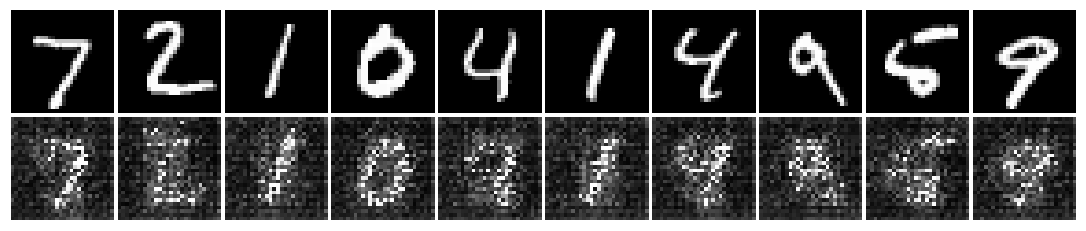

epoch 1 | iter 15 | loss 0.26435
epoch 1 | iter 20 | loss 0.19634


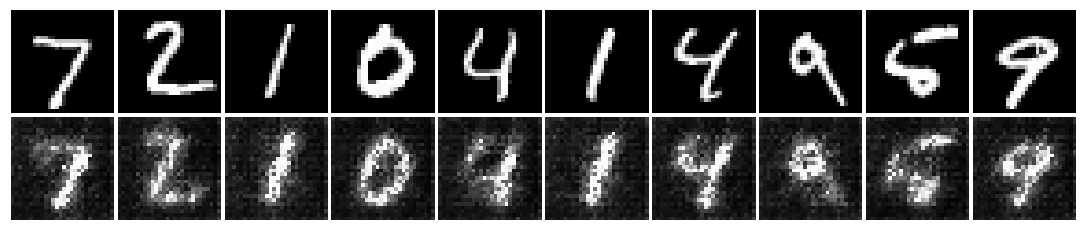

epoch 1 | iter 25 | loss 0.15335
epoch 1 | iter 30 | loss 0.12540


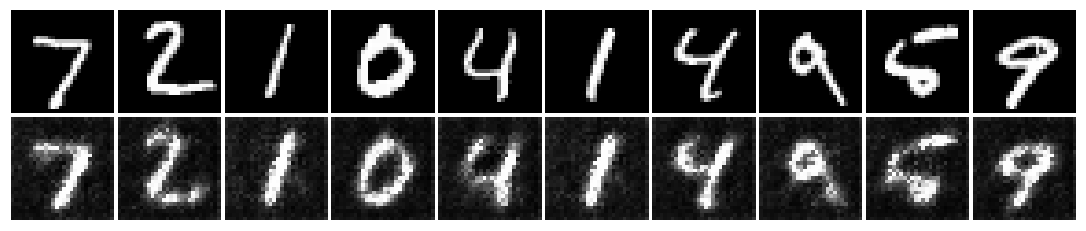

epoch 1 | iter 35 | loss 0.10499
epoch 1 | iter 40 | loss 0.08720


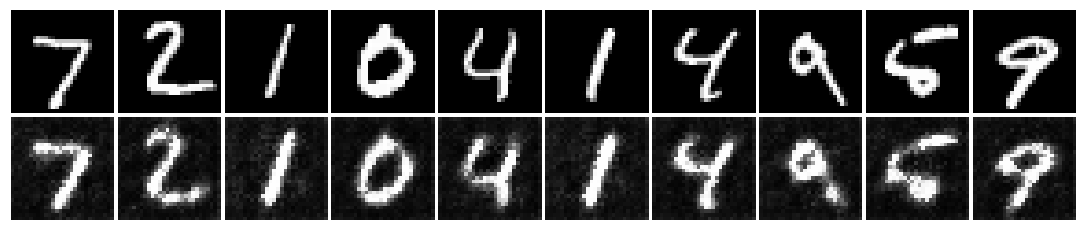

epoch 1 | iter 45 | loss 0.07648
epoch 1 | iter 50 | loss 0.06886


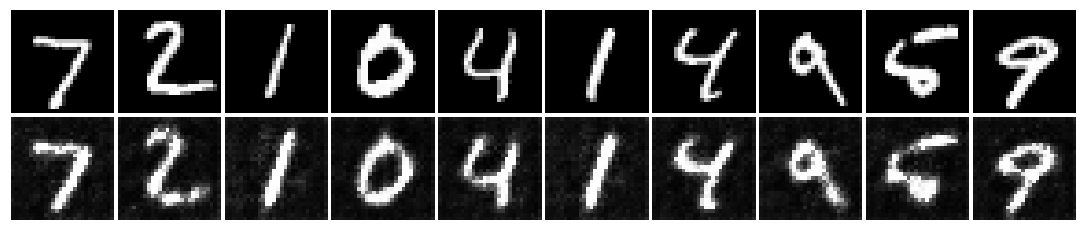

epoch 1 | iter 55 | loss 0.06220
epoch 1 | iter 60 | loss 0.05677


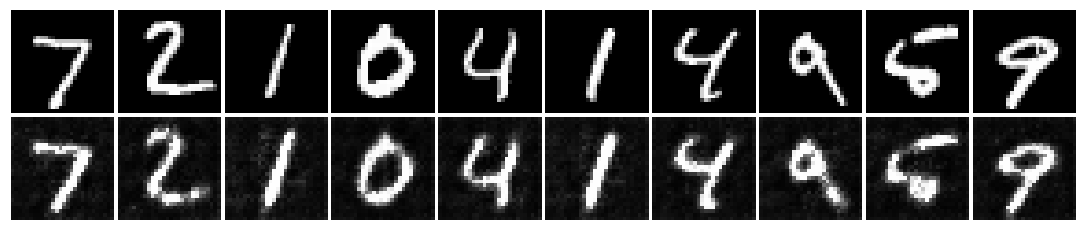

epoch 1 | iter 65 | loss 0.05032
epoch 1 | iter 70 | loss 0.04807


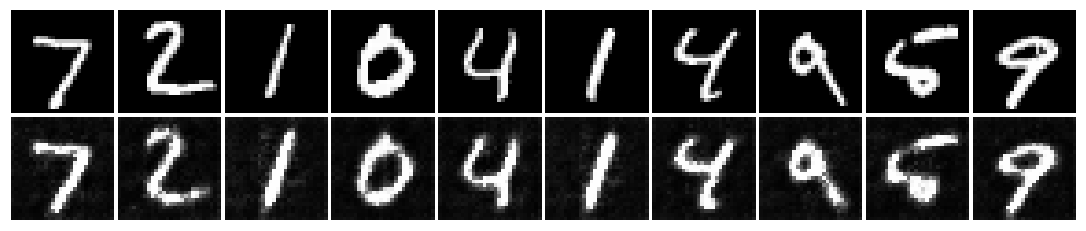

epoch 1 | iter 75 | loss 0.04460
epoch 1 | iter 80 | loss 0.04137


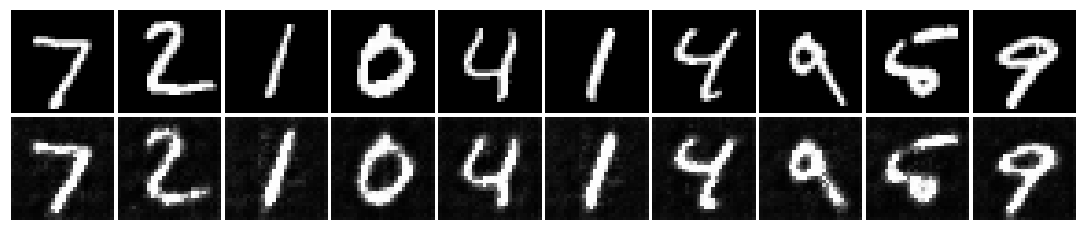

epoch 1 | iter 85 | loss 0.03958
epoch 1 | iter 90 | loss 0.03719


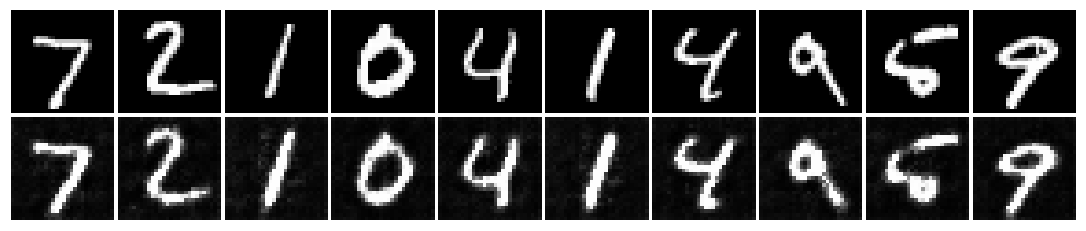

epoch 1 | iter 95 | loss 0.03583
epoch 1 | iter 100 | loss 0.03386


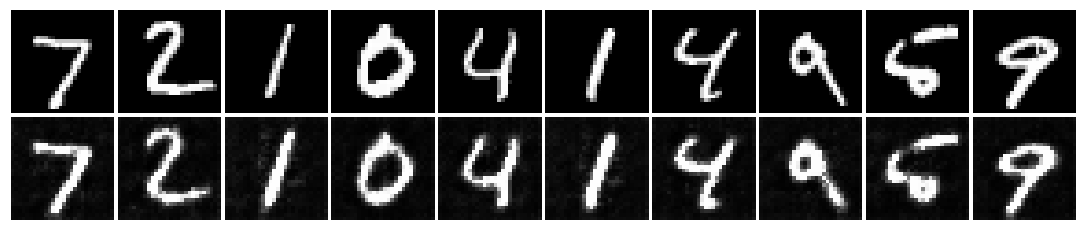

epoch 1 | iter 105 | loss 0.03211
epoch 1 | iter 110 | loss 0.03167


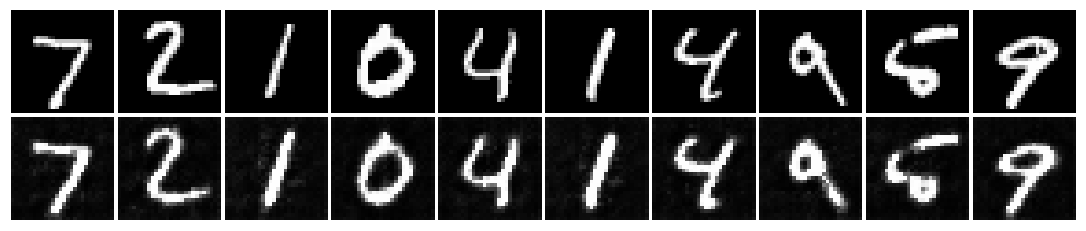

epoch 1 | iter 115 | loss 0.03090
epoch 1 | iter 120 | loss 0.03023


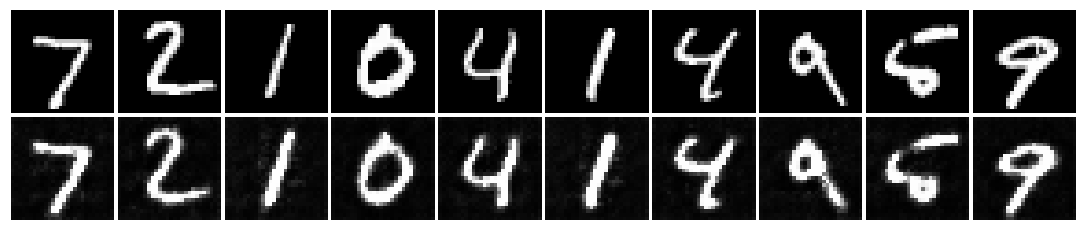

epoch 1 | iter 125 | loss 0.02885
epoch 1 | iter 130 | loss 0.02768


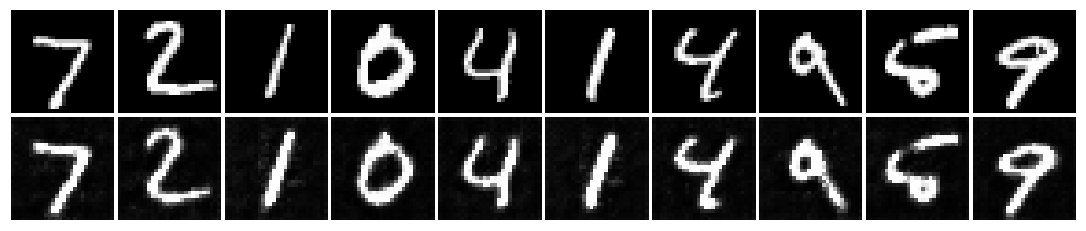

epoch 1 | iter 135 | loss 0.02704
epoch 1 | iter 140 | loss 0.02629


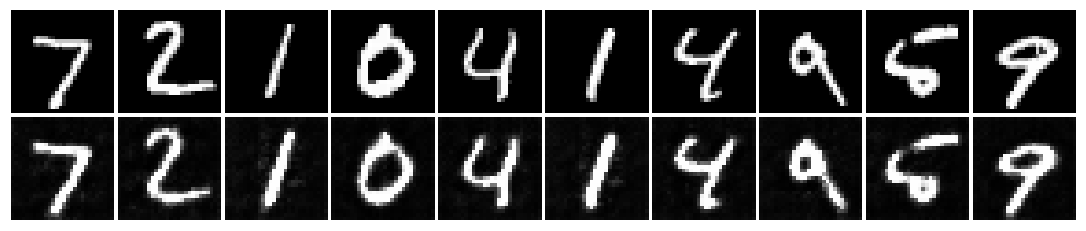

epoch 1 | iter 145 | loss 0.02512
epoch 1 | iter 150 | loss 0.02498


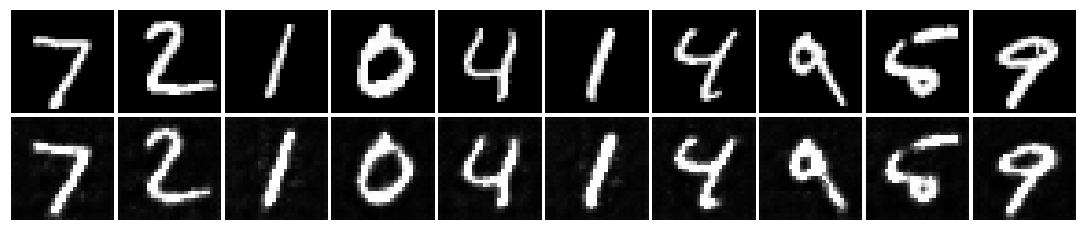

epoch 1 | iter 155 | loss 0.02539
epoch 1 | iter 160 | loss 0.02390


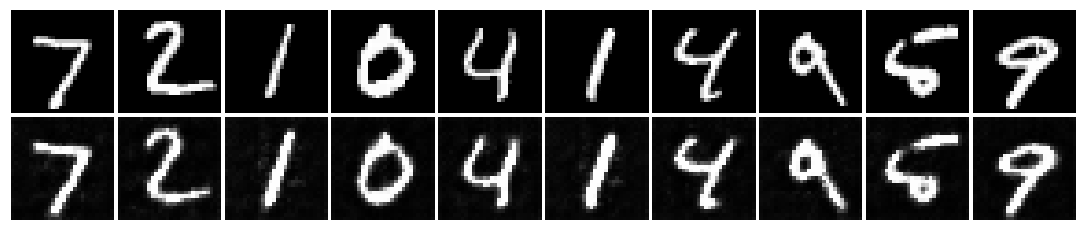

epoch 1 | iter 165 | loss 0.02398
epoch 1 | iter 170 | loss 0.02262


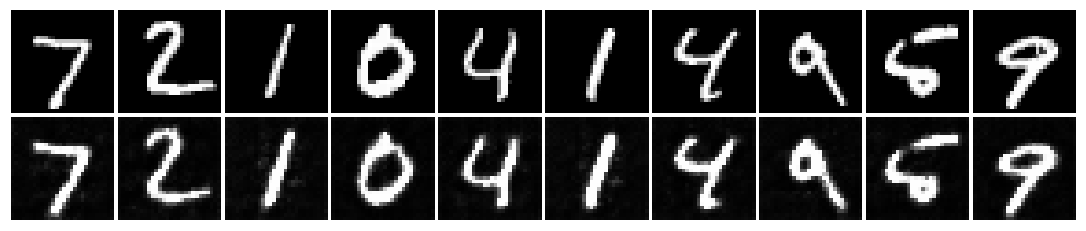

epoch 1 | iter 175 | loss 0.02347
epoch 1 | iter 180 | loss 0.02264


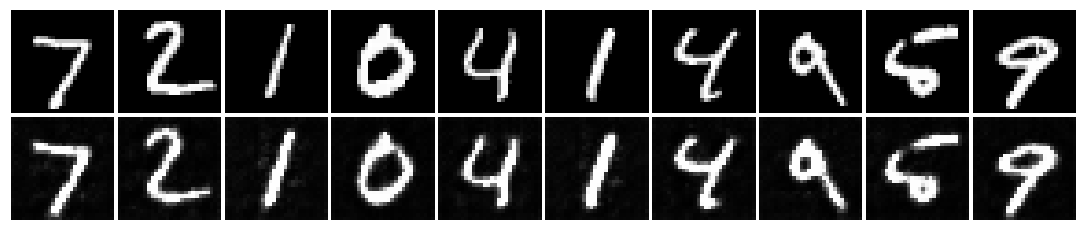

epoch 1 | iter 185 | loss 0.02126
epoch 1 | iter 190 | loss 0.02092


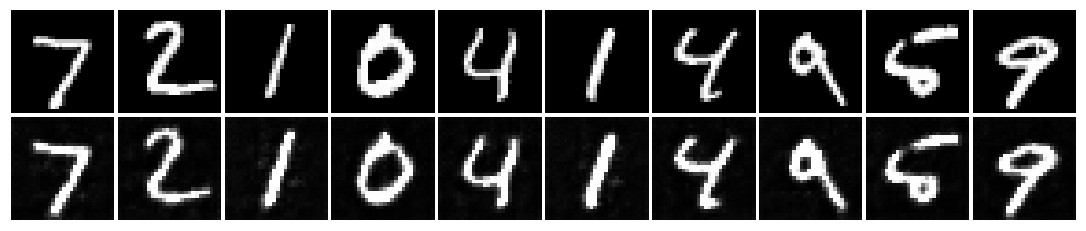

epoch 1 | iter 195 | loss 0.02075
epoch 1 | iter 200 | loss 0.01997


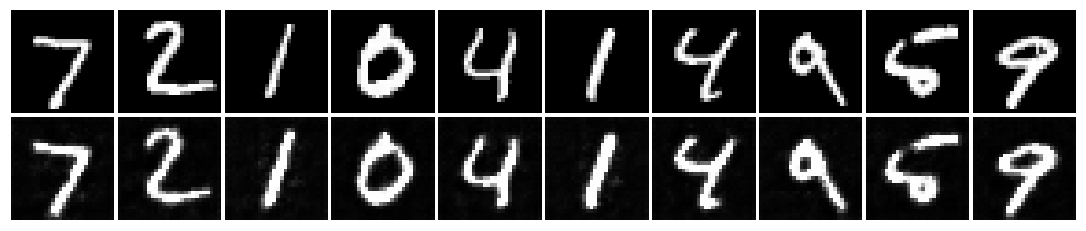

epoch 1 | iter 205 | loss 0.02011
epoch 1 | iter 210 | loss 0.01954


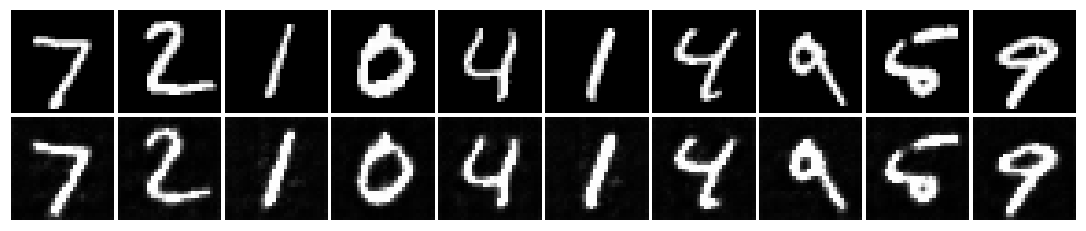

epoch 1 | iter 215 | loss 0.01889
epoch 1 | iter 220 | loss 0.01908


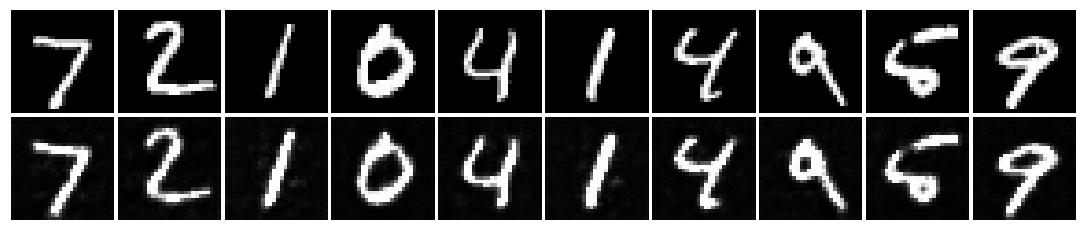

epoch 1 | iter 225 | loss 0.01921
epoch 1 | iter 230 | loss 0.01926


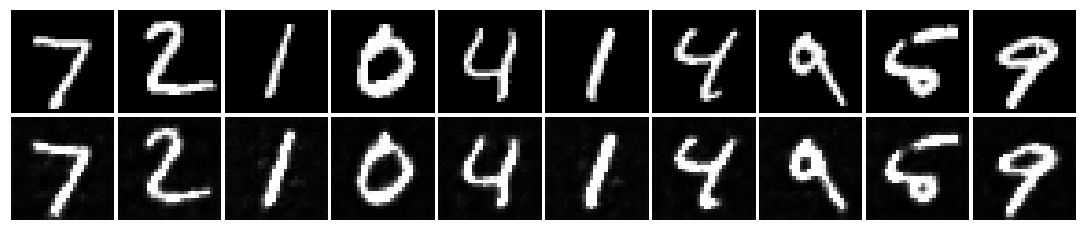

epoch 1 | iter 235 | loss 0.01867
epoch 1 | iter 240 | loss 0.01864


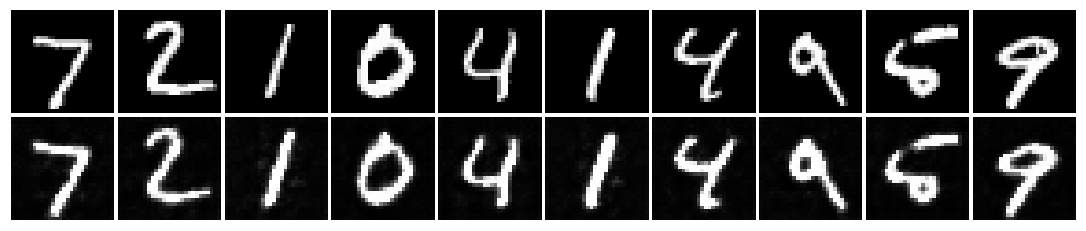

epoch 1 | iter 245 | loss 0.01780
epoch 1 | iter 250 | loss 0.01759


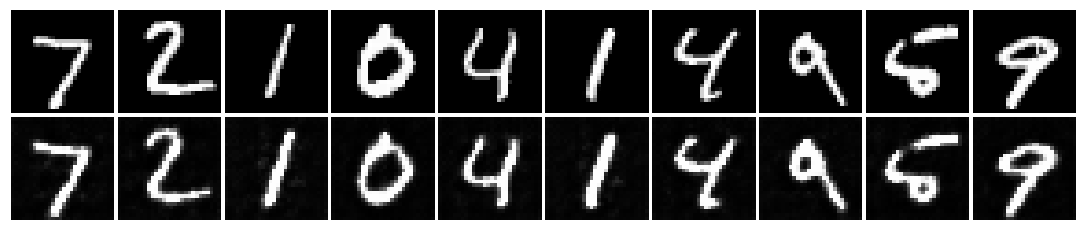

In [217]:
def validate(valid_dl: DataLoader, 
             model: nn.Module,
             crit):
    
    total_loss = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(valid_dl):
            x = x.cuda()
            
            x_recon = model(x)
            
            loss = crit(x, x_recon)
            
            total_loss += loss.item()
            
    return total_loss

def show_summary(valid_dl: DataLoader, model: DataLoader):
    
    N_SAMPLES = 10
    
    actuals, preds = [], []
    with torch.no_grad():
        for i, (x, y) in enumerate(valid_dl.dataset):
            
            actuals.append(denorm(x))
            
            recon_x = model(x.unsqueeze(0).cuda()).cpu()
            
            preds.append(denorm(recon_x.squeeze(0)))
            
            if i + 1 == N_SAMPLES:
                break
            
    grid = make_grid([*actuals, *preds], pad_value=1, padding=1, nrow=N_SAMPLES)

    plt.figure(figsize=(20, 4))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()
        
def train(train_dl: DataLoader, 
          valid_dl: DataLoader,
          model: nn.Module,
          n_epochs: int,
          max_iters: int = -1):
    
    LOG_INTERVAL = 5
    SUMMARY_INTERVAL = 10
    
    model = model.cuda()
    
    crit = nn.MSELoss(reduction='mean')
    optim = torch.optim.Adam(model.parameters())
    
    acc_loss = 0
    
    i = 1
    for epoch in range(n_epochs):
        for x, _ in train_dl:
            
            optim.zero_grad()
            
            x = x.cuda()
            
            x_recon = model(x)
            
            loss = crit(x, x_recon)
            
            acc_loss += loss.item()
            
            loss.backward()
            
            optim.step()
            
            if (i + 1) % LOG_INTERVAL == 0:
                print('epoch %d | iter %d | loss %.5f' % (epoch + 1, i + 1, acc_loss / LOG_INTERVAL))
                acc_loss = 0
                
            if (i + 1) % SUMMARY_INTERVAL == 0:
                show_summary(valid_dl, model)
                
            i += 1
            
            if i == max_iters:
                return
            
                      
m = nn.Sequential(Enc(), Dec())
train(train_dl, valid_dl, m, 1, 250)                      

In [200]:
x.mean(), x.max(), x.mean(), x.std()

(tensor(-0.7419), tensor(1.), tensor(-0.7419), tensor(0.6141))

In [187]:
o = nn.Sequential(Enc(), Dec())(x)

In [191]:
o.mean(), o.min()

(tensor(0.0320, grad_fn=<MeanBackward0>),
 tensor(-1.0000, grad_fn=<MinBackward1>))